In [1]:
!pip install -q scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 69.6 MB/s eta 0:00:00


# Imports & Setup

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, AdamW, Nadam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from scipy.stats import uniform, loguniform
import matplotlib.pyplot as plt
from IPython.display import clear_output
import uuid

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%matplotlib inline

# Custom Callbacks

In [3]:
class VisualizePredictionsCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to visualize predictions at the end of each epoch.
    """
    def __init__(self, X, y, num_samples=5, save_plot=False):
        super(VisualizePredictionsCallback, self).__init__()
        self.X = X
        self.y = y
        self.num_samples = num_samples
        self.save_plot = save_plot

    def on_epoch_end(self, epoch, logs=None):
        print(f"[Callback] VisualizePredictionsCallback: Epoch {epoch+1} ended.")
        # Select random samples
        indices = np.random.choice(len(self.X), self.num_samples, replace=False)
        sample_images = self.X[indices]
        sample_labels = self.y[indices]

        # Generate predictions
        predictions = self.model.predict(sample_images)
        predicted_labels = np.argmax(predictions, axis=1)

        # Plot the images with predictions
        plt.figure(figsize=(15, 5))
        plt.subplots_adjust(top=0.80)
        plt.suptitle(f"Epoch {epoch+1} Prediction Sample", fontsize=16, y=0.93)

        for i in range(self.num_samples):
            plt.subplot(1, self.num_samples, i+1)
            if sample_images[i].ndim == 3:
                plt.imshow(sample_images[i], cmap='gray')
            else:
                plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
            title_color = 'green' if predicted_labels[i] == sample_labels[i] else 'red'
            plt.title(f"Pred: {predicted_labels[i]}\nTrue: {sample_labels[i]}", color=title_color, fontsize=10)

        if self.save_plot:
            filename = f'epoch_{epoch+1}_predictions_{uuid.uuid4().hex}.png'
            plt.savefig(filename)
            print(f"[Callback] Saved predictions plot for epoch {epoch+1} as {filename}")

        plt.tight_layout(rect=[0, 0.03, 1, 0.88])
        plt.show()

class PlotHistoryCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to plot training and validation history at the end of training.
    """
    def __init__(self, save_plot=False):
        super(PlotHistoryCallback, self).__init__()
        self.save_plot = save_plot
        self.history = {}

    def on_train_begin(self, logs=None):
        print("[Callback] PlotHistoryCallback: Training started.")
        # Initialize history for the metrics
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        # Append metrics for each epoch
        for key in self.history.keys():
            self.history[key].append(logs.get(key))
        print(f"[Callback] PlotHistoryCallback: Epoch {epoch+1} ended. Logs: {logs}")

    def on_train_end(self, logs=None):
        print("[Callback] PlotHistoryCallback: Training ended. Plotting history.")
        epochs = range(1, len(self.history['loss']) + 1)

        # Plot Loss
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['loss'], 'b-', label='Training Loss')
        plt.plot(epochs, self.history['val_loss'], 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        if self.history['accuracy'] and self.history['val_accuracy']:
            plt.plot(epochs, self.history['accuracy'], 'b-', label='Training Accuracy')
            plt.plot(epochs, self.history['val_accuracy'], 'r-', label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)
        else:
            print("No accuracy data to plot.")

        plt.tight_layout()

        if self.save_plot:
            filename = f'training_history_{uuid.uuid4().hex}.png'
            plt.savefig(filename)
            print(f"[Callback] Training history plot saved as {filename}")

        plt.show()

# Callback Factory

In [4]:
def create_callbacks(callback_params, X=None, y=None):
    """
    Creates a list of Keras callbacks based on the provided parameters.

    Parameters:
    - callback_params (dict): Dictionary containing callback configurations.
    - X (numpy.ndarray): Input data for visualization callbacks (optional).
    - y (numpy.ndarray): Labels for visualization callbacks (optional).

    Returns:
    - List of instantiated Keras callbacks.
    """
    callbacks = []

    # EarlyStopping
    if callback_params.get('callback_early_stopping_enabled', False):
        es = EarlyStopping(
            monitor=callback_params.get('callback_early_stopping_monitor', 'val_loss'),
            patience=callback_params.get('callback_early_stopping_patience', 5),
            restore_best_weights=callback_params.get('callback_early_stopping_restore_best_weights', True),
            verbose=callback_params.get('callback_early_stopping_verbose', 1)
        )
        callbacks.append(es)
        print("[Factory] Added EarlyStopping callback.")

    # ReduceLROnPlateau
    if callback_params.get('callback_reduce_lr_enabled', False):
        rl = ReduceLROnPlateau(
            monitor=callback_params.get('callback_reduce_lr_monitor', 'val_loss'),
            factor=callback_params.get('callback_reduce_lr_factor', 0.2),
            patience=callback_params.get('callback_reduce_lr_patience', 3),
            min_lr=callback_params.get('callback_reduce_lr_min_lr', 1e-5),
            verbose=callback_params.get('callback_reduce_lr_verbose', 1)
        )
        callbacks.append(rl)
        print("[Factory] Added ReduceLROnPlateau callback.")

    # VisualizePredictionsCallback
    if callback_params.get('callback_visualize_enabled', False) and X is not None and y is not None:
        vp = VisualizePredictionsCallback(
            X=X,
            y=y,
            num_samples=callback_params.get('callback_visualize_num_samples', 5),
            save_plot=callback_params.get('callback_visualize_save_plot', False)
        )
        callbacks.append(vp)
        print("[Factory] Added VisualizePredictionsCallback.")

    # PlotHistoryCallback
    if callback_params.get('callback_plot_history_enabled', False):
        ph = PlotHistoryCallback(
            save_plot=callback_params.get('callback_plot_history_save_plot', False)
        )
        callbacks.append(ph)
        print("[Factory] Added PlotHistoryCallback.")

    return callbacks

# Model Builder

In [5]:
def build_model(n_hidden=1,
                n_neurons=32,
                learning_rate=0.001,
                optimizer='Adam',
                activation_function='relu',
                kernel_initializer='he_normal',
                add_dropout=False,
                dropout_rate=0.2,
                add_batch_normalization=False,
                **kwargs):
    """
    Builds and compiles a Keras Sequential model based on provided hyperparameters.

    Parameters:
    - n_hidden (int): Number of hidden Dense layers.
    - n_neurons (int): Number of neurons in each hidden Dense layer.
    - learning_rate (float): Learning rate for the optimizer.
    - optimizer (str): Optimizer name ('Adam', 'Nadam', etc.).
    - activation_function (str): Activation function for Dense layers.
    - kernel_initializer (str): Kernel initializer for Dense layers.
    - add_dropout (bool): Whether to add Dropout layers.
    - dropout_rate (float): Dropout rate if Dropout layers are added.
    - add_batch_normalization (bool): Whether to add BatchNormalization layers.

    Returns:
    - Compiled Keras model.
    """
    model = Sequential()
    model.add(Input(shape=(28, 28)))
    model.add(Flatten())

    for i in range(n_hidden):
        model.add(Dense(n_neurons, activation=activation_function, kernel_initializer=kernel_initializer, name=f'hidden_{i+1}'))
        if add_dropout:
            model.add(Dropout(dropout_rate, name=f'dropout_{i+1}'))
        if add_batch_normalization:
            model.add(BatchNormalization(name=f'batch_norm_{i+1}'))

    # Output layer for classification
    model.add(Dense(10, activation='softmax', name='output'))  # 10 classes for MNIST
    loss = 'sparse_categorical_crossentropy'
    metrics = ['accuracy']

    # Select optimizer
    optimizer_map = {
        'Adam': Adam,
        'AdamW': AdamW,
        'Nadam': Nadam,
        'RMSprop': RMSprop
        # Add other optimizers as needed
    }

    optimizer_class = optimizer_map.get(optimizer)
    if not optimizer_class:
        raise ValueError(f"Optimizer '{optimizer}' is not supported.")

    opt = optimizer_class(learning_rate=learning_rate)

    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=metrics)

    print(f"[Function] build_model: Classification model has been built and compiled.")
    return model

# Model Wrapper

In [6]:
class KerasClassifierWithCallbacks(KerasClassifier):
    """
    Custom SciKeras KerasClassifier that integrates tunable callback parameters and model-building parameters.
    """

    def __init__(self, model, **kwargs):
        # Extract callback parameters
        self.callback_params = {}
        for k in list(kwargs.keys()):
            if k.startswith('callback_'):
                self.callback_params[k] = kwargs.pop(k)
        self.X_visualize = kwargs.pop('X_visualize', None)
        self.y_visualize = kwargs.pop('y_visualize', None)
        super().__init__(model=model, **kwargs)

    def get_params(self, deep=True):
        params = super().get_params(deep=deep)
        # Include custom parameters
        params.update(self.callback_params)
        params['X_visualize'] = self.X_visualize
        params['y_visualize'] = self.y_visualize
        return params

    def set_params(self, **params):
        # Extract custom callback parameters
        for k in list(params.keys()):
            if k.startswith('callback_'):
                self.callback_params[k] = params.pop(k)
        self.X_visualize = params.pop('X_visualize', self.X_visualize)
        self.y_visualize = params.pop('y_visualize', self.y_visualize)
        # Do not modify 'model__' parameters
        super().set_params(**params)
        return self

    def fit(self, X, y, **kwargs):
        # Create callbacks based on parameters
        callbacks = create_callbacks(
            callback_params=self.callback_params,
            X=self.X_visualize,
            y=self.y_visualize
        )
        # Set 'fit__callbacks' via 'set_params' so scikeras can handle it
        self.set_params(fit__callbacks=callbacks)
        return super().fit(X, y, **kwargs)

# Loading Data

In [8]:
def load_data():
    """
    Loads and preprocesses the MNIST dataset for classification.

    Returns:
    - X_train (numpy.ndarray): Training images.
    - y_train (numpy.ndarray): Training labels.
    - X_test (numpy.ndarray): Testing images.
    - y_test (numpy.ndarray): Testing labels.
    """
    print("[Data] Loading MNIST dataset...")
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize the data
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    print("[Data] Data loaded and normalized for classification.")

    return X_train, y_train, X_test, y_test

# Hyperparameter Distributions

In [9]:
def define_hyperparameter_distributions():
    """
    Defines the hyperparameter search space, including model and callback parameters.

    Returns:
    - param_distributions (dict): Dictionary of hyperparameter distributions.
    """
    param_distributions = {
        # Model hyperparameters
        'model__n_hidden': [1, 2, 3],
        'model__n_neurons': [64, 128, 256],
        'model__learning_rate': loguniform(1e-4, 1e-2),
        'model__optimizer': ['Adam', 'AdamW', 'Nadam'],
        'model__activation_function': ['relu', 'selu'],
        'model__kernel_initializer': ['he_normal', 'glorot_normal'],
        'model__add_dropout': [True, False],
        'model__dropout_rate': uniform(0.1, 0.3),
        'model__add_batch_normalization': [True, False],

        # Callback hyperparameters
        'callback_early_stopping_enabled': [True],
        'callback_early_stopping_monitor': ['val_loss', 'val_accuracy'],
        'callback_early_stopping_patience': [3, 5],
        'callback_early_stopping_restore_best_weights': [True, False],
        'callback_early_stopping_verbose': [0, 1],

        'callback_reduce_lr_enabled': [True],
        'callback_reduce_lr_monitor': ['val_loss'],
        'callback_reduce_lr_factor': [0.1, 0.2],
        'callback_reduce_lr_patience': [2, 3],
        'callback_reduce_lr_min_lr': loguniform(1e-5, 1e-3),
        'callback_reduce_lr_verbose': [0, 1],

        'callback_visualize_enabled': [False],  # Disabled during tuning
        'callback_visualize_num_samples': [3, 5],
        'callback_visualize_save_plot': [False],

        'callback_plot_history_enabled': [False],  # Disabled during tuning
        'callback_plot_history_save_plot': [False]
    }
    return param_distributions

# Hyperparameter Search

In [10]:
def perform_hyperparameter_tuning(X_train, y_train, X_visualize, y_visualize, param_distributions, n_iter=20, cv=3):
    """
    Performs hyperparameter tuning using RandomizedSearchCV.

    Parameters:
    - X_train (numpy.ndarray): Training images.
    - y_train (numpy.ndarray): Training labels.
    - X_visualize (numpy.ndarray): Images for visualization callbacks.
    - y_visualize (numpy.ndarray): Labels for visualization callbacks.
    - param_distributions (dict): Hyperparameter distributions.
    - n_iter (int): Number of parameter settings that are sampled.
    - cv (int): Number of cross-validation folds.

    Returns:
    - random_search (RandomizedSearchCV object): The fitted RandomizedSearchCV object.
    """
    print("[Tuning] Initializing KerasClassifierWithCallbacks...")
    clf = KerasClassifierWithCallbacks(
        model=build_model,
        X_visualize=X_visualize,
        y_visualize=y_visualize,
        epochs=20,
        batch_size=128,
        validation_split=0.1,
        verbose=0
    )

    print("[Tuning] Setting up RandomizedSearchCV...")
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        verbose=3,
        n_jobs=1,
        random_state=42
    )

    print("[Tuning] Starting hyperparameter search...")
    random_search.fit(X_train, y_train)
    print("[Tuning] Hyperparameter search completed.")
    return random_search

# Model Evaluation

In [11]:
def evaluate_results(random_search, X_test, y_test):
    """
    Evaluates and prints the best hyperparameters and corresponding scores.

    Parameters:
    - random_search (RandomizedSearchCV object): The fitted RandomizedSearchCV object.
    - X_test (numpy.ndarray): Testing images.
    - y_test (numpy.ndarray): Testing labels.
    """
    print("\n===================================")
    print("            Best Model             ")
    print("===================================")
    print("Best Hyperparameters:")
    for param, value in random_search.best_params_.items():
        print(f"{param}: {value}")

    print(f"\nBest Cross-Validation Score: {random_search.best_score_:.4f}")

    print("\nEvaluating on Test Data...")
    test_score = random_search.best_estimator_.score(X_test, y_test)
    print(f"Test Accuracy: {test_score:.4f}")
    print("===================================\n")

# Model Retraining

In [12]:
def retrain_best_model(random_search, X_train, y_train, X_test, y_test, X_visualize, y_visualize):
    """
    Retrains the model using the best hyperparameters identified during hyperparameter tuning
    and evaluates its performance on the test set.

    Parameters:
    - random_search (RandomizedSearchCV object): The fitted RandomizedSearchCV object containing best parameters.
    - X_train (numpy.ndarray): Training images.
    - y_train (numpy.ndarray): Training labels.
    - X_test (numpy.ndarray): Testing images.
    - y_test (numpy.ndarray): Testing labels.
    - X_visualize (numpy.ndarray): Images for visualization callbacks.
    - y_visualize (numpy.ndarray): Labels for visualization callbacks.

    Returns:
    - best_model (KerasClassifierWithCallbacks object): The retrained and evaluated model.
    """
    # Extract the best parameters
    best_params = random_search.best_params_
    print("[Retrain] Best Hyperparameters:", best_params)

    # Modify callback parameters to enable visualization and history plotting
    best_params['callback_visualize_enabled'] = True
    best_params['callback_plot_history_enabled'] = True

    # Initialize the KerasClassifier with the best parameters
    best_model = KerasClassifierWithCallbacks(
        model=build_model,
        X_visualize=X_visualize,
        y_visualize=y_visualize,
        epochs=20,
        batch_size=128,
        validation_split=0.1,
        verbose=1
    )

    # Set the best parameters
    best_model.set_params(**best_params)

    # Retrain the model on the entire training set
    print("[Retrain] Starting training with best hyperparameters...")
    best_model.fit(X_train, y_train)
    print("[Retrain] Training completed.")

    # Evaluate the model on the test set
    test_score = best_model.score(X_test, y_test)
    print(f"[Retrain] Test Accuracy: {test_score:.4f}")

    return best_model

# Execution Function

[Main] Executing task: Classification
[Data] Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
[Data] Data loaded and normalized for classification.
[Tuning] Initializing KerasClassifierWithCallbacks...
[Tuning] Setting up RandomizedSearchCV...
[Tuning] Starting hyperparameter search...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Factory] Added EarlyStopping callback.
[Factory] Added ReduceLROnPlateau callback.
[Function] build_model: Classification model has been built and compiled.
[CV 1/3] END callback_early_stopping_enabled=True, callback_early_stopping_monitor=val_loss, callback_early_stopping_patience=5, callback_early_stopping_restore_best_weights=True, callback_early_stopping_verbose=0, callback_plot_history_enabled=False, callback_plot_history_save_plot=False, callback_reduce_lr_enabled=True, callback_reduce_lr_factor=0.1, callback_reduce_lr_min_lr=0.00036256176345762266, callback_reduce_lr_monitor=val_loss, callback_reduce_lr_patience

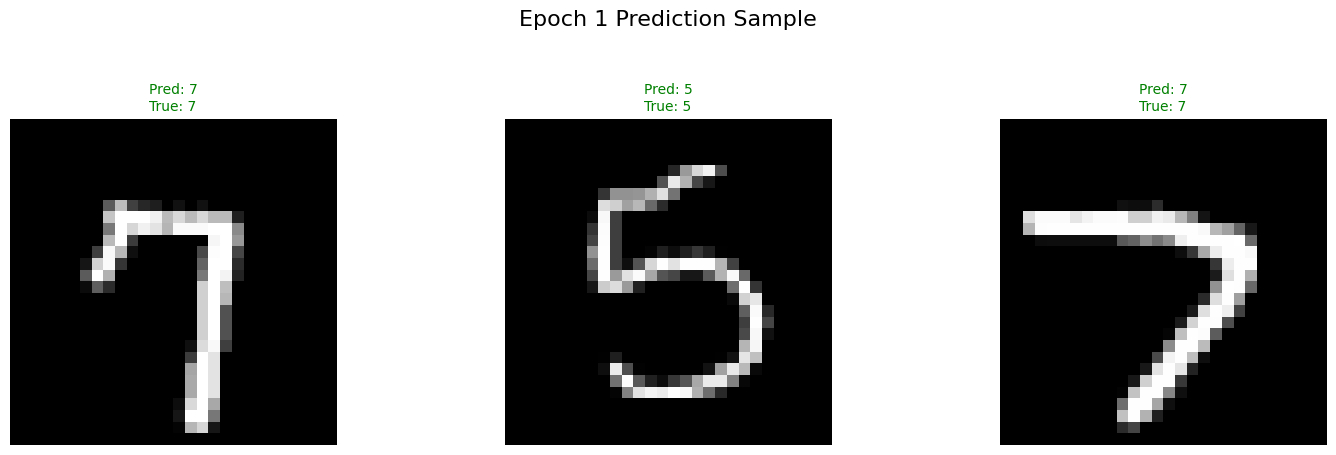

[Callback] PlotHistoryCallback: Epoch 1 ended. Logs: {'accuracy': 0.9033703804016113, 'loss': 0.3229188621044159, 'val_accuracy': 0.9558333158493042, 'val_loss': 0.15146510303020477, 'learning_rate': 0.00038234752719290555}
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8382 - loss: 0.5286 - val_accuracy: 0.9558 - val_loss: 0.1515 - learning_rate: 3.8235e-04
Epoch 2/20
405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9493 - loss: 0.1708[Callback] VisualizePredictionsCallback: Epoch 2 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


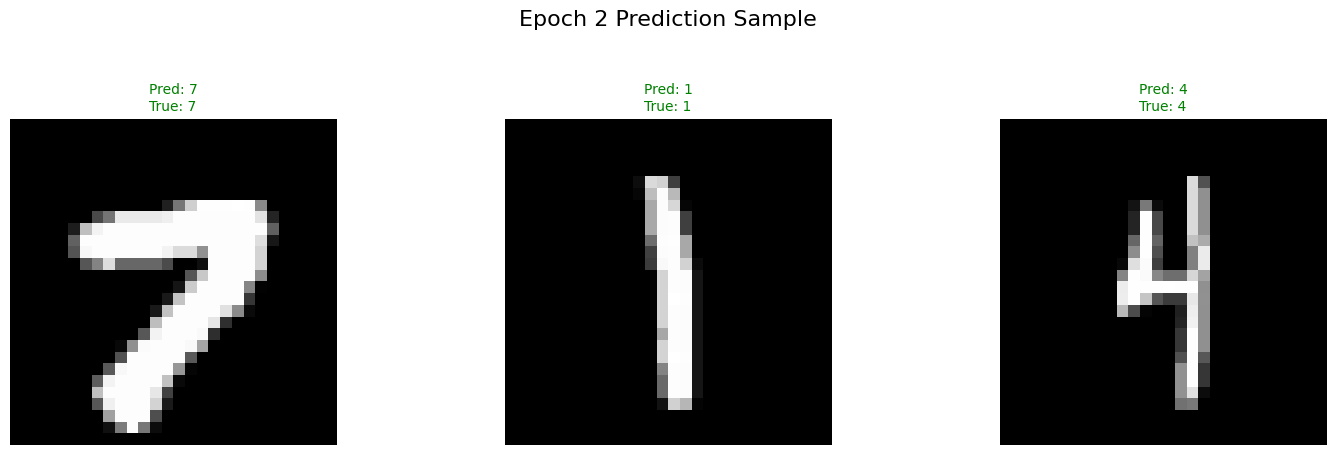

[Callback] PlotHistoryCallback: Epoch 2 ended. Logs: {'accuracy': 0.9535555839538574, 'loss': 0.15679830312728882, 'val_accuracy': 0.9660000205039978, 'val_loss': 0.11071164160966873, 'learning_rate': 0.00038234752719290555}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9495 - loss: 0.1702 - val_accuracy: 0.9660 - val_loss: 0.1107 - learning_rate: 3.8235e-04
Epoch 3/20
397/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.1131[Callback] VisualizePredictionsCallback: Epoch 3 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


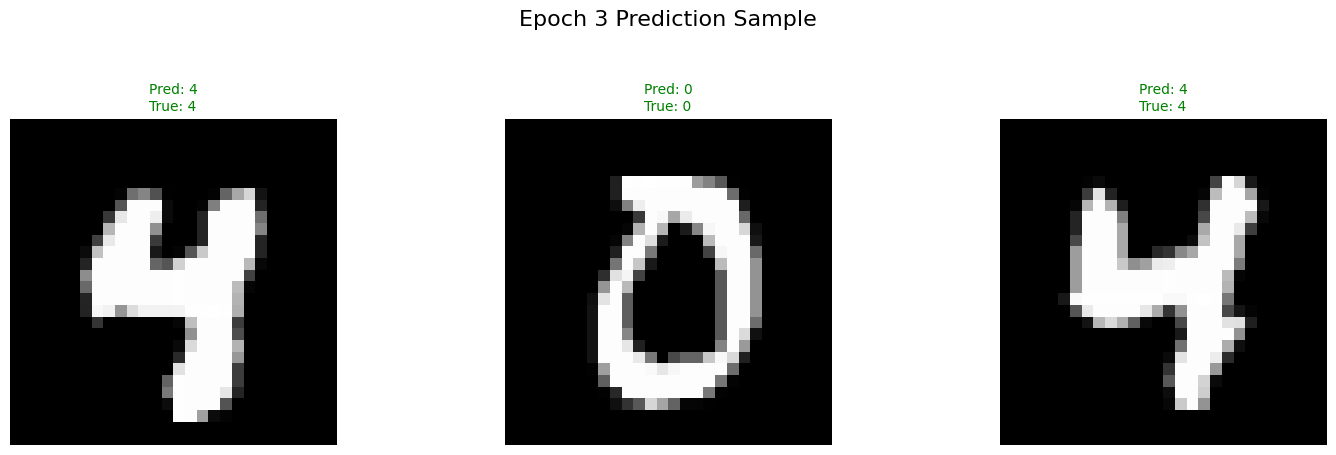

[Callback] PlotHistoryCallback: Epoch 3 ended. Logs: {'accuracy': 0.9677407145500183, 'loss': 0.10714912414550781, 'val_accuracy': 0.9691666960716248, 'val_loss': 0.09418261051177979, 'learning_rate': 0.00038234752719290555}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9661 - loss: 0.1127 - val_accuracy: 0.9692 - val_loss: 0.0942 - learning_rate: 3.8235e-04
Epoch 4/20
410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 0.0821[Callback] VisualizePredictionsCallback: Epoch 4 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


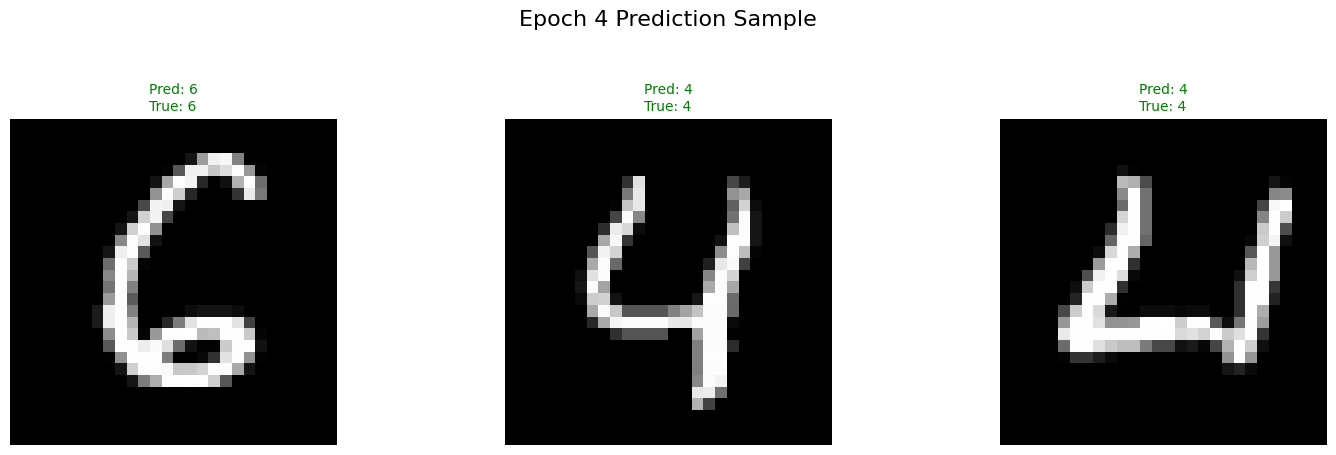

[Callback] PlotHistoryCallback: Epoch 4 ended. Logs: {'accuracy': 0.9763148427009583, 'loss': 0.07939032465219498, 'val_accuracy': 0.9721666574478149, 'val_loss': 0.08753003180027008, 'learning_rate': 0.00038234752719290555}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9756 - loss: 0.0821 - val_accuracy: 0.9722 - val_loss: 0.0875 - learning_rate: 3.8235e-04
Epoch 5/20
418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0626[Callback] VisualizePredictionsCallback: Epoch 5 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


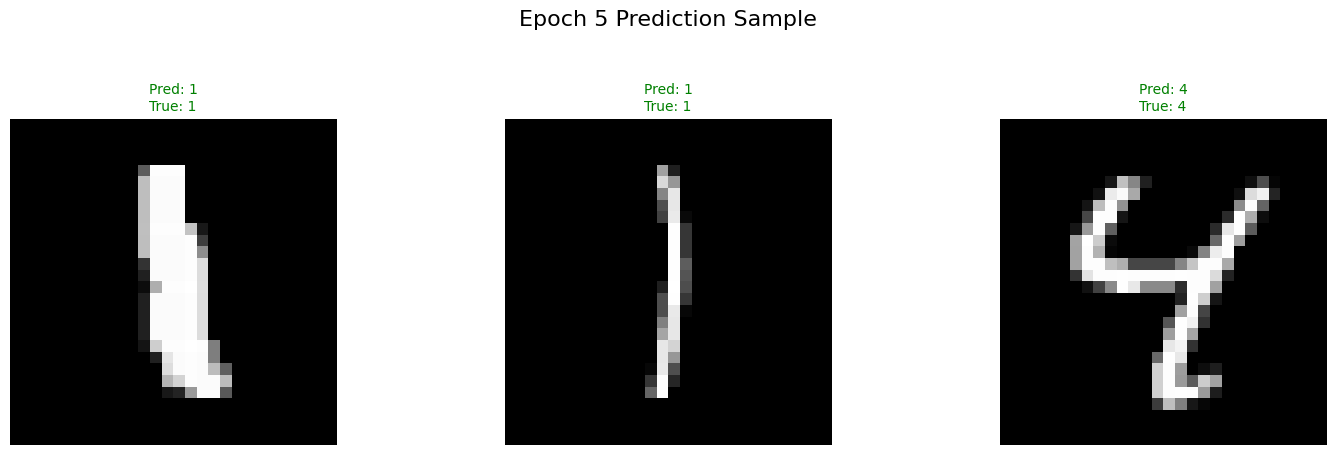

[Callback] PlotHistoryCallback: Epoch 5 ended. Logs: {'accuracy': 0.9820185303688049, 'loss': 0.06075695902109146, 'val_accuracy': 0.9733333587646484, 'val_loss': 0.08474084734916687, 'learning_rate': 0.00038234752719290555}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9815 - loss: 0.0625 - val_accuracy: 0.9733 - val_loss: 0.0847 - learning_rate: 3.8235e-04
Epoch 6/20
411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0486[Callback] VisualizePredictionsCallback: Epoch 6 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


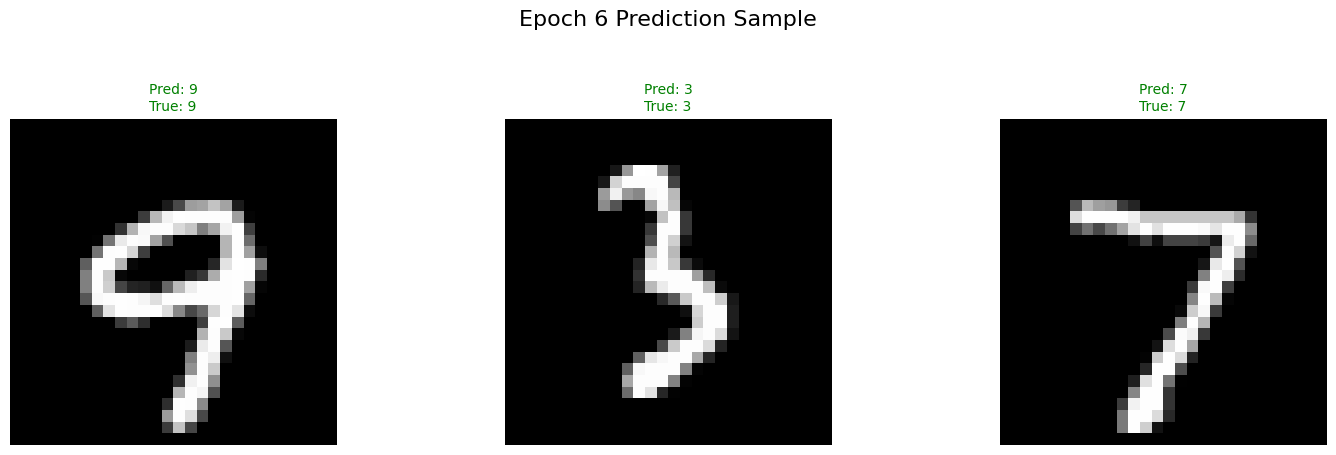

[Callback] PlotHistoryCallback: Epoch 6 ended. Logs: {'accuracy': 0.986907422542572, 'loss': 0.04708585515618324, 'val_accuracy': 0.9736666679382324, 'val_loss': 0.08386071026325226, 'learning_rate': 0.00038234752719290555}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9864 - loss: 0.0486 - val_accuracy: 0.9737 - val_loss: 0.0839 - learning_rate: 3.8235e-04
Epoch 7/20
408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0387[Callback] VisualizePredictionsCallback: Epoch 7 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


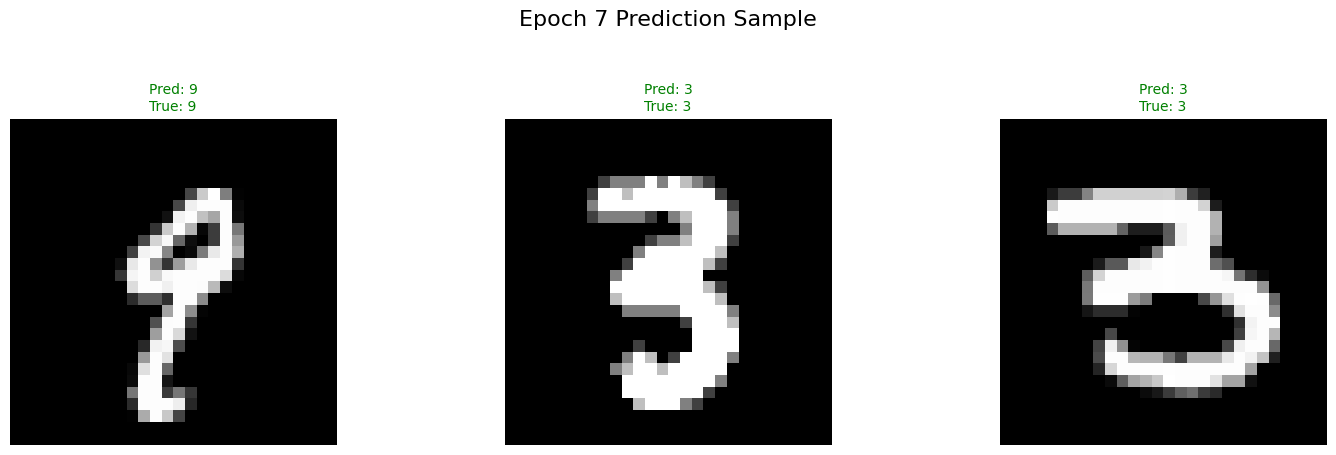

[Callback] PlotHistoryCallback: Epoch 7 ended. Logs: {'accuracy': 0.990240752696991, 'loss': 0.03698981925845146, 'val_accuracy': 0.9723333120346069, 'val_loss': 0.08616288006305695, 'learning_rate': 0.00038234752719290555}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9900 - loss: 0.0386 - val_accuracy: 0.9723 - val_loss: 0.0862 - learning_rate: 3.8235e-04
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0306[Callback] VisualizePredictionsCallback: Epoch 8 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


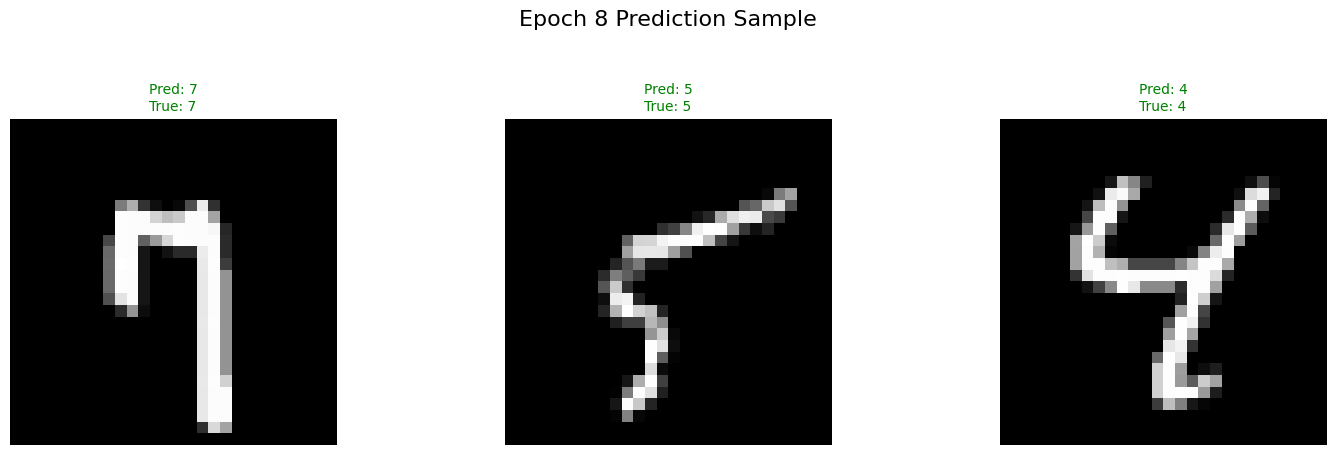

[Callback] PlotHistoryCallback: Epoch 8 ended. Logs: {'accuracy': 0.9925370216369629, 'loss': 0.029133081436157227, 'val_accuracy': 0.9721666574478149, 'val_loss': 0.09036727994680405, 'learning_rate': 0.00038234752719290555}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9924 - loss: 0.0306 - val_accuracy: 0.9722 - val_loss: 0.0904 - learning_rate: 3.8235e-04
Epoch 9/20
398/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0243[Callback] VisualizePredictionsCallback: Epoch 9 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


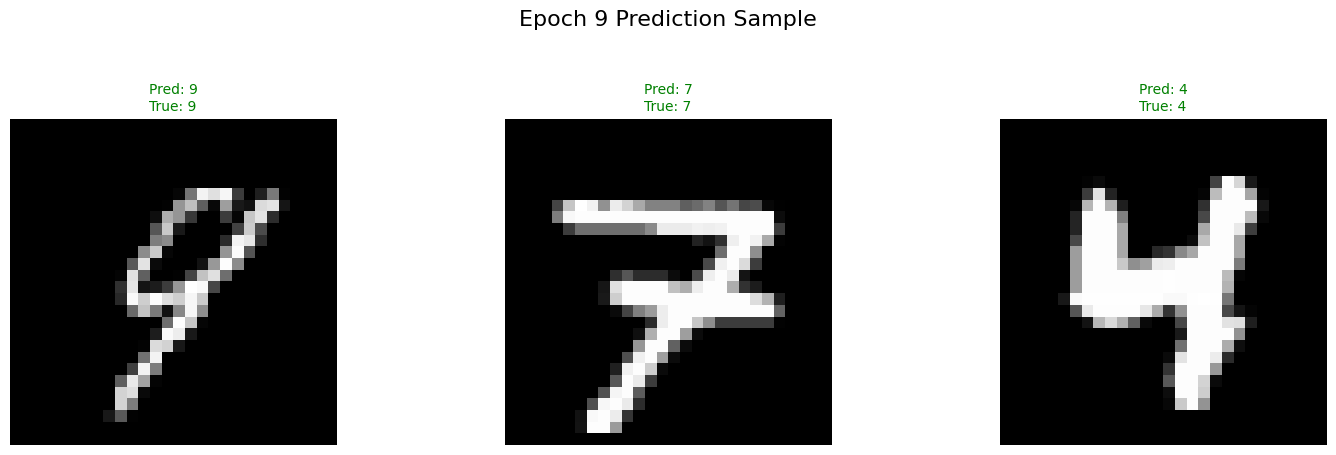

[Callback] PlotHistoryCallback: Epoch 9 ended. Logs: {'accuracy': 0.9942777752876282, 'loss': 0.023301072418689728, 'val_accuracy': 0.9711666703224182, 'val_loss': 0.09412532299757004, 'learning_rate': 0.00038234752719290555}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9940 - loss: 0.0242 - val_accuracy: 0.9712 - val_loss: 0.0941 - learning_rate: 3.8235e-04
Epoch 10/20
415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0178[Callback] VisualizePredictionsCallback: Epoch 10 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


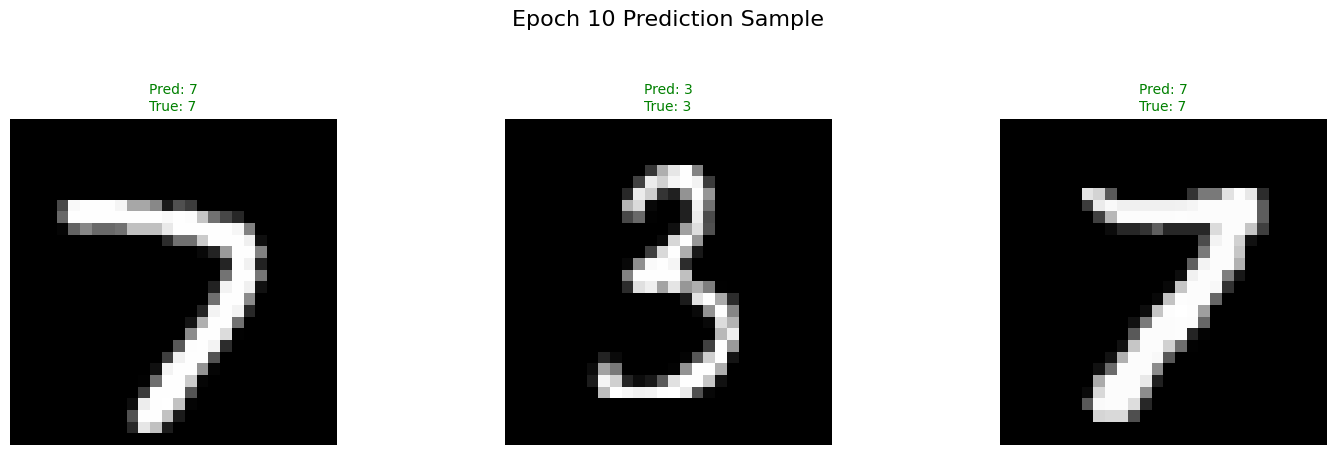

[Callback] PlotHistoryCallback: Epoch 10 ended. Logs: {'accuracy': 0.9957592487335205, 'loss': 0.015336225740611553, 'val_accuracy': 0.9821666479110718, 'val_loss': 0.06816533207893372, 'learning_rate': 7.646950689377263e-05}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9949 - loss: 0.0178 - val_accuracy: 0.9822 - val_loss: 0.0682 - learning_rate: 7.6470e-05
Epoch 11/20
417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0115[Callback] VisualizePredictionsCallback: Epoch 11 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


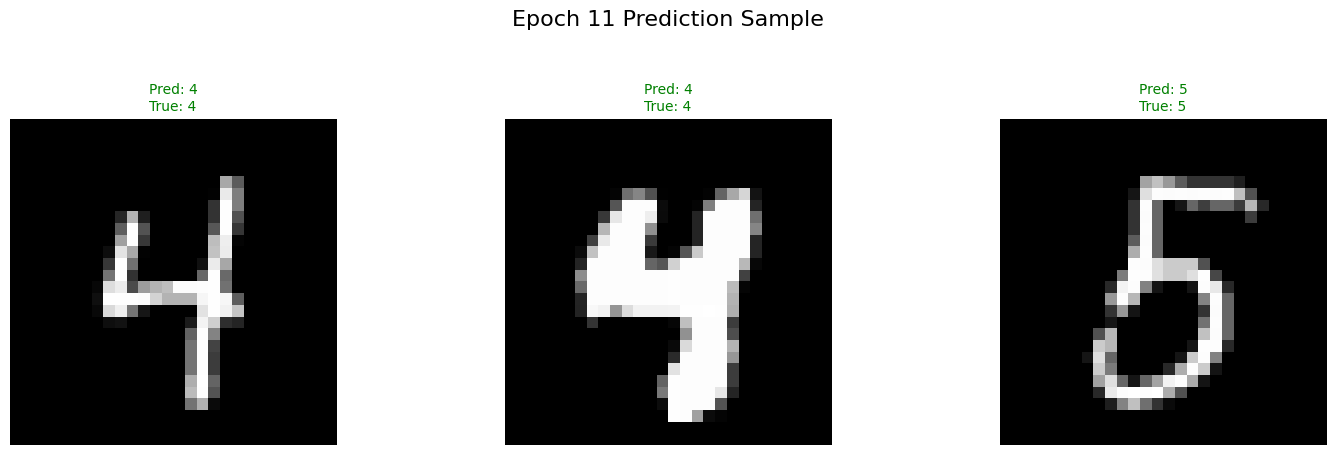

[Callback] PlotHistoryCallback: Epoch 11 ended. Logs: {'accuracy': 0.9978703856468201, 'loss': 0.011103706434369087, 'val_accuracy': 0.9823333621025085, 'val_loss': 0.06785725802183151, 'learning_rate': 7.646950689377263e-05}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9976 - loss: 0.0115 - val_accuracy: 0.9823 - val_loss: 0.0679 - learning_rate: 7.6470e-05
Epoch 12/20
419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0097[Callback] VisualizePredictionsCallback: Epoch 12 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


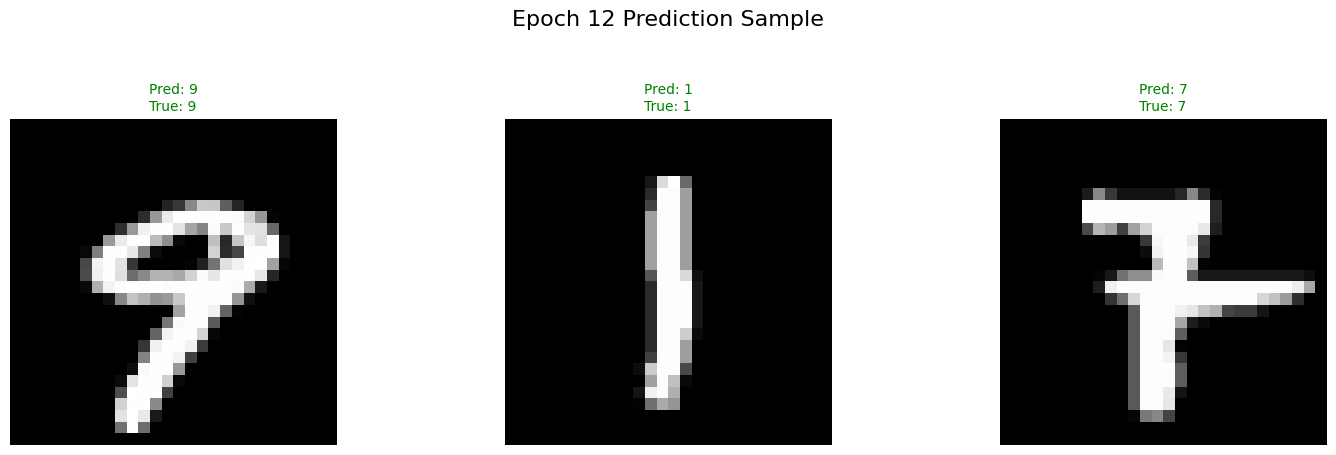

[Callback] PlotHistoryCallback: Epoch 12 ended. Logs: {'accuracy': 0.9986481666564941, 'loss': 0.009521310217678547, 'val_accuracy': 0.9828333258628845, 'val_loss': 0.06778708100318909, 'learning_rate': 7.646950689377263e-05}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9985 - loss: 0.0097 - val_accuracy: 0.9828 - val_loss: 0.0678 - learning_rate: 7.6470e-05
Epoch 13/20
413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0085[Callback] VisualizePredictionsCallback: Epoch 13 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


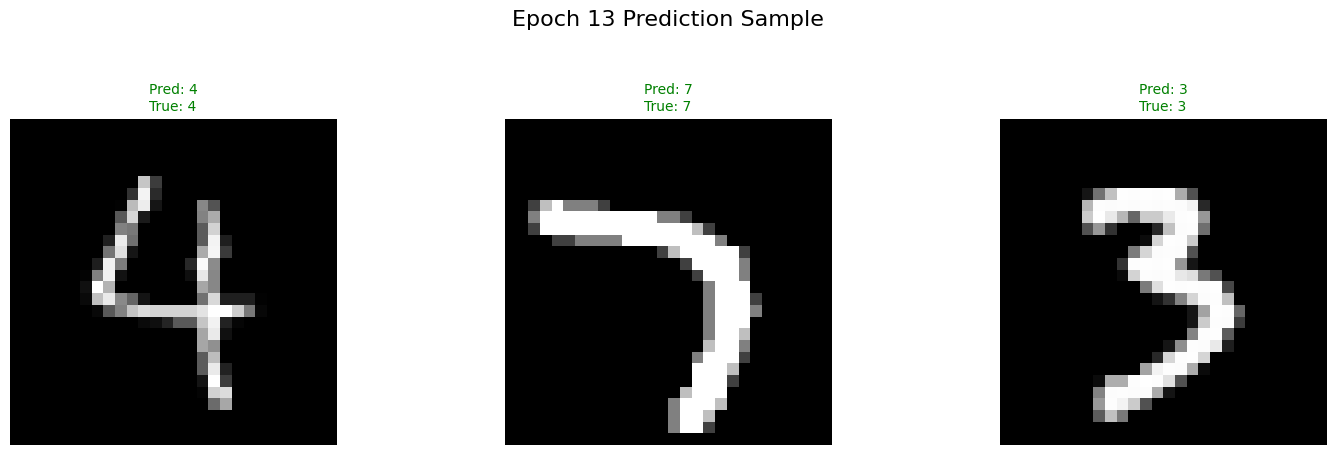

[Callback] PlotHistoryCallback: Epoch 13 ended. Logs: {'accuracy': 0.9991296529769897, 'loss': 0.008429995737969875, 'val_accuracy': 0.9833333492279053, 'val_loss': 0.06789505481719971, 'learning_rate': 7.646950689377263e-05}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9990 - loss: 0.0085 - val_accuracy: 0.9833 - val_loss: 0.0679 - learning_rate: 7.6470e-05
Epoch 14/20
413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0076[Callback] VisualizePredictionsCallback: Epoch 14 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


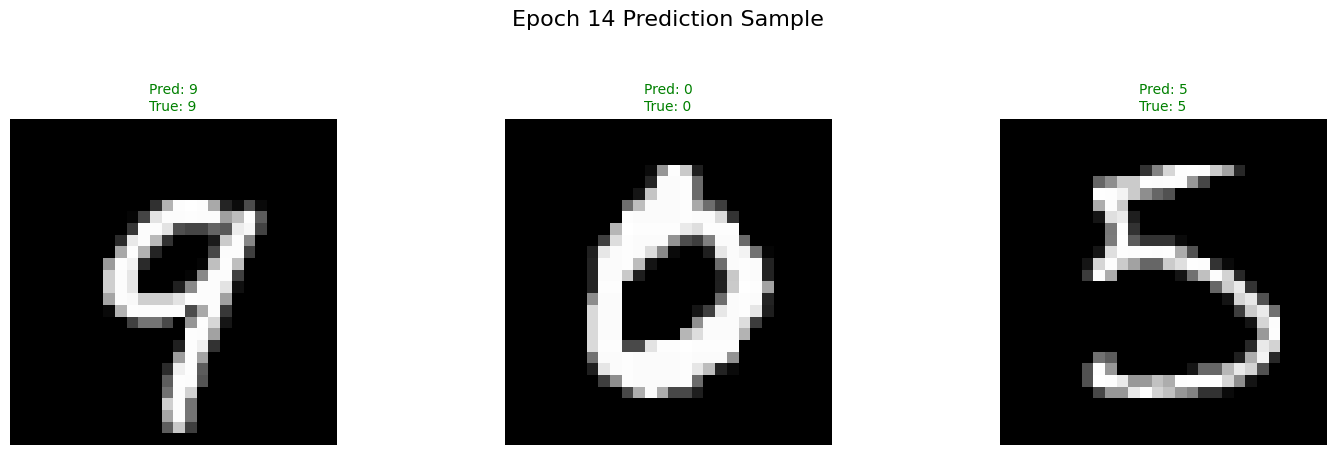

[Callback] PlotHistoryCallback: Epoch 14 ended. Logs: {'accuracy': 0.9993333220481873, 'loss': 0.007537450175732374, 'val_accuracy': 0.9835000038146973, 'val_loss': 0.06822072714567184, 'learning_rate': 7.646950689377263e-05}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9992 - loss: 0.0076 - val_accuracy: 0.9835 - val_loss: 0.0682 - learning_rate: 7.6470e-05
Epoch 15/20
405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0067[Callback] VisualizePredictionsCallback: Epoch 15 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


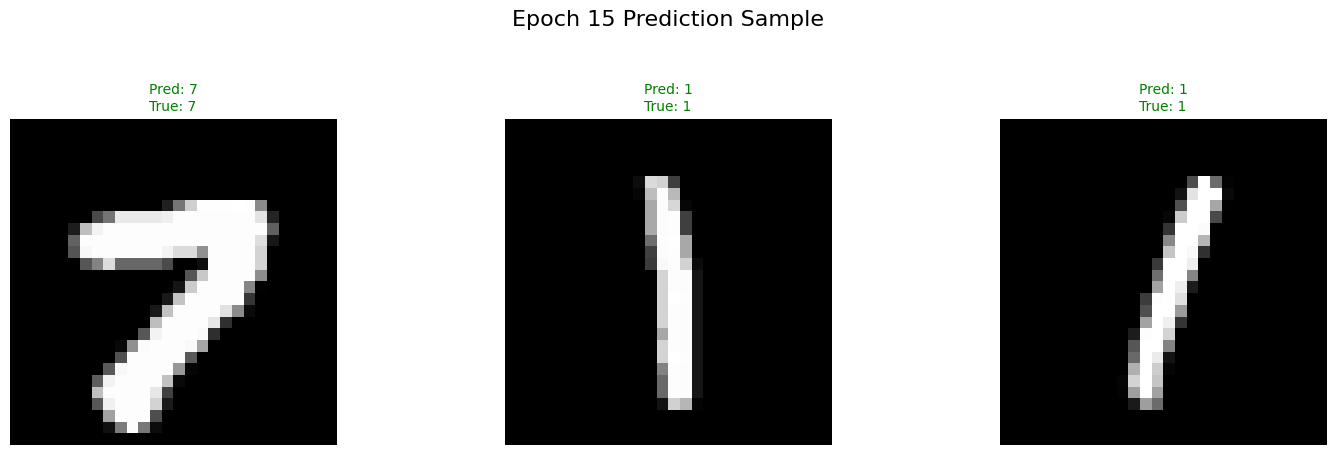

[Callback] PlotHistoryCallback: Epoch 15 ended. Logs: {'accuracy': 0.9994444251060486, 'loss': 0.006248702295124531, 'val_accuracy': 0.9829999804496765, 'val_loss': 0.06715554744005203, 'learning_rate': 1.5293901014956646e-05}
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9993 - loss: 0.0067 - val_accuracy: 0.9830 - val_loss: 0.0672 - learning_rate: 1.5294e-05
Epoch 16/20
410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0060[Callback] VisualizePredictionsCallback: Epoch 16 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


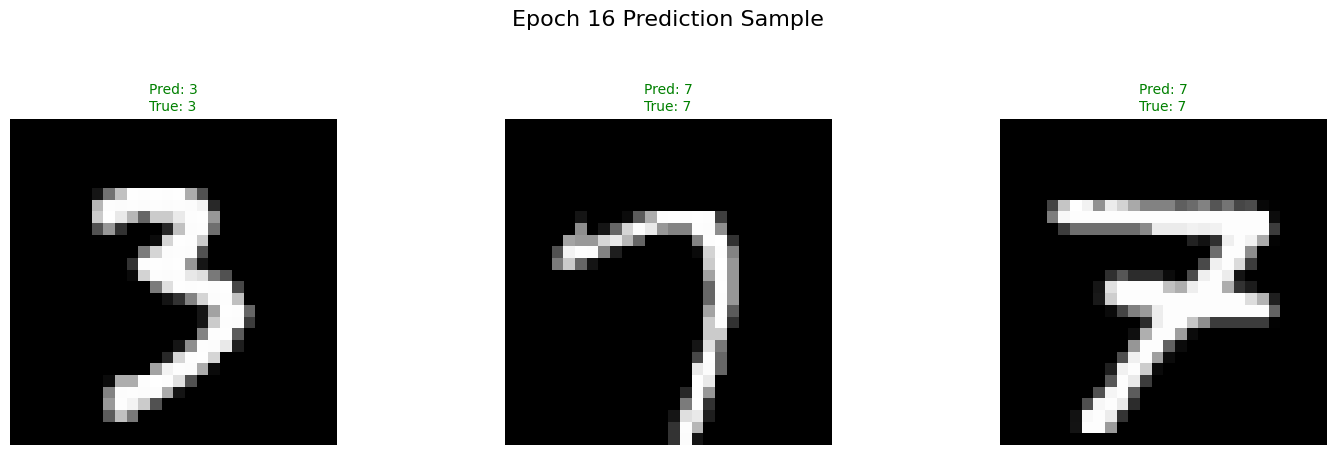

[Callback] PlotHistoryCallback: Epoch 16 ended. Logs: {'accuracy': 0.9995555281639099, 'loss': 0.005788120441138744, 'val_accuracy': 0.9829999804496765, 'val_loss': 0.06745018810033798, 'learning_rate': 1.5293901014956646e-05}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9995 - loss: 0.0060 - val_accuracy: 0.9830 - val_loss: 0.0675 - learning_rate: 1.5294e-05
Epoch 17/20
410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0057[Callback] VisualizePredictionsCallback: Epoch 17 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


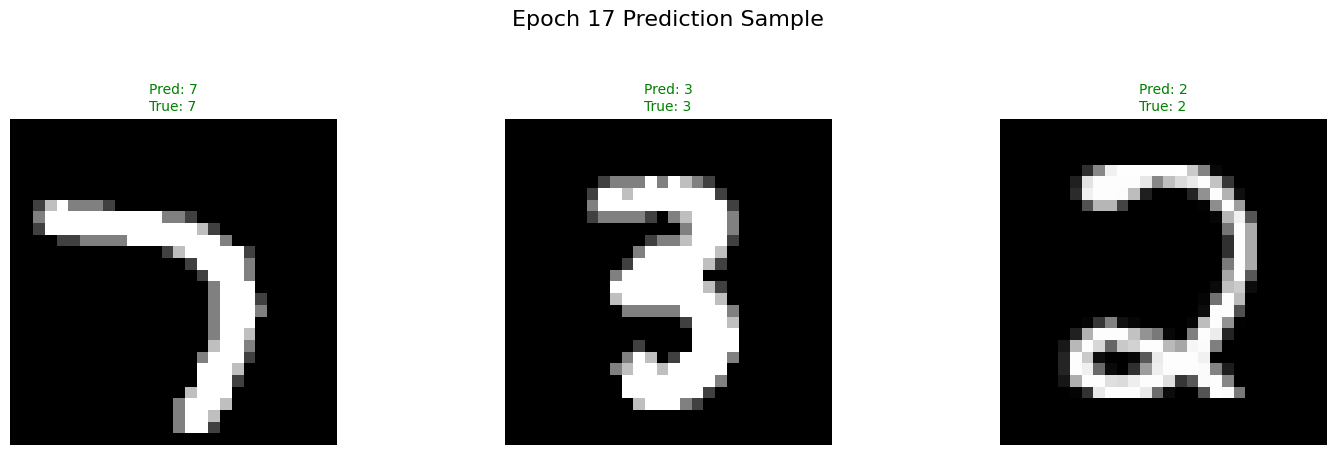

[Callback] PlotHistoryCallback: Epoch 17 ended. Logs: {'accuracy': 0.9995740652084351, 'loss': 0.005594182759523392, 'val_accuracy': 0.9829999804496765, 'val_loss': 0.06760329008102417, 'learning_rate': 1.5293901014956646e-05}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9995 - loss: 0.0057 - val_accuracy: 0.9830 - val_loss: 0.0676 - learning_rate: 1.5294e-05
Epoch 18/20
397/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0055[Callback] VisualizePredictionsCallback: Epoch 18 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


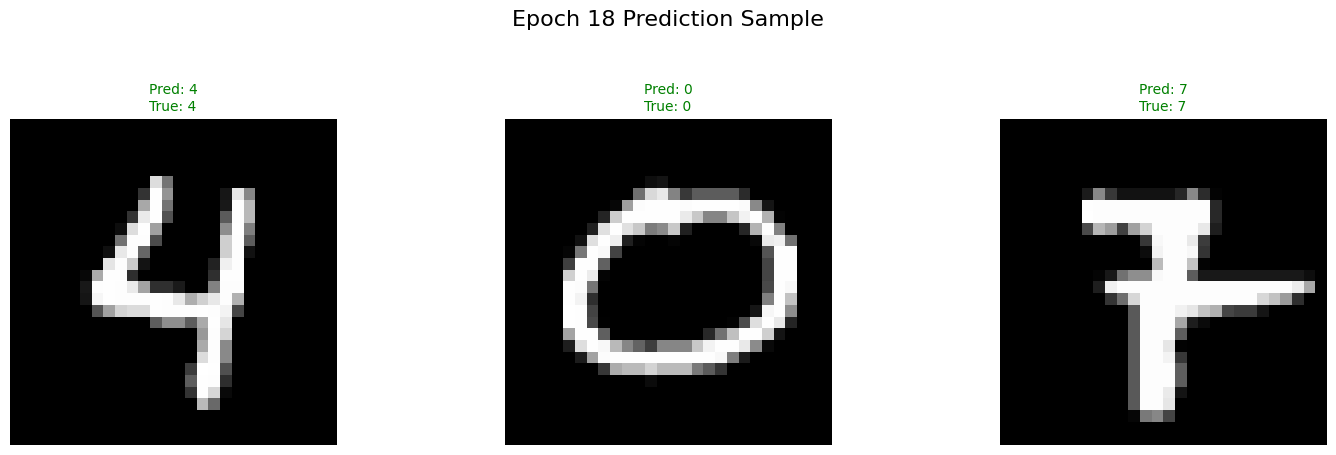

[Callback] PlotHistoryCallback: Epoch 18 ended. Logs: {'accuracy': 0.9996111392974854, 'loss': 0.005417970474809408, 'val_accuracy': 0.9829999804496765, 'val_loss': 0.0677037164568901, 'learning_rate': 1.5293901014956646e-05}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0055 - val_accuracy: 0.9830 - val_loss: 0.0677 - learning_rate: 1.5294e-05
Epoch 19/20
405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0053[Callback] VisualizePredictionsCallback: Epoch 19 ended.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


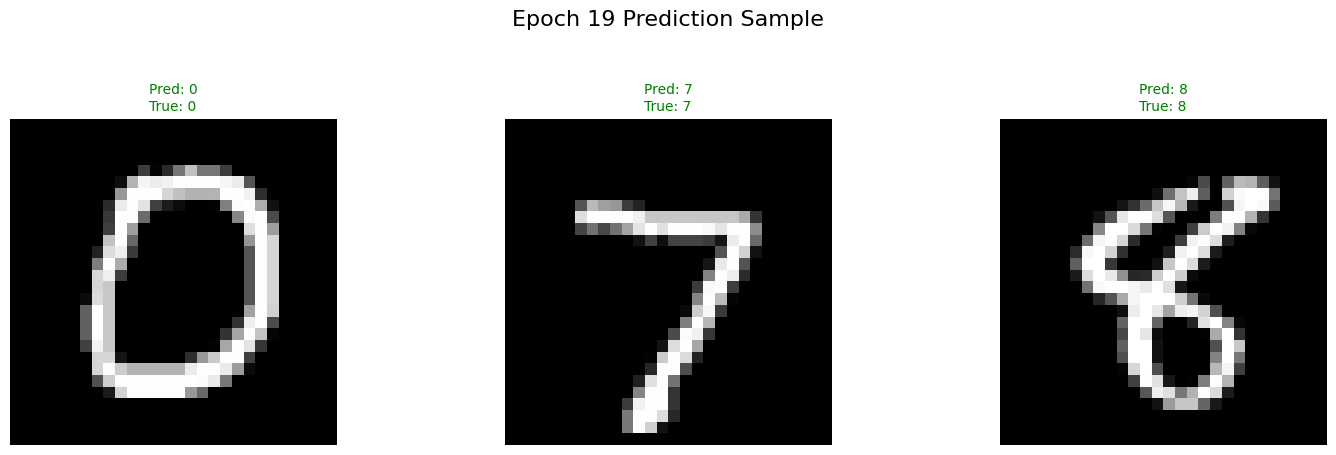

[Callback] PlotHistoryCallback: Epoch 19 ended. Logs: {'accuracy': 0.9996296167373657, 'loss': 0.005175422411412001, 'val_accuracy': 0.9829999804496765, 'val_loss': 0.0676354467868805, 'learning_rate': 1.0035927516582888e-05}
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0053 - val_accuracy: 0.9830 - val_loss: 0.0676 - learning_rate: 1.0036e-05
Epoch 19: early stopping
[Callback] PlotHistoryCallback: Training ended. Plotting history.


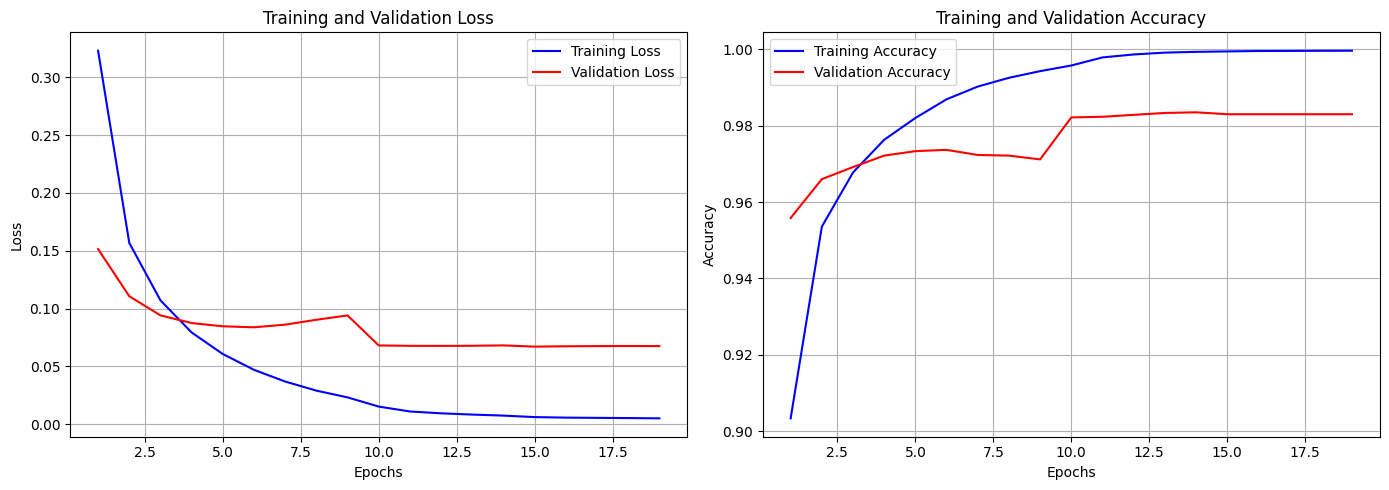

[Retrain] Training completed.
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[Retrain] Test Accuracy: 0.9803
[Retrain] Model saved to 'best_mnist_classifier.keras'.


In [13]:
def main():
    """
    Main function to execute the hyperparameter tuning workflow.
    """
    print(f"[Main] Executing task: Classification")

    # Step 1: Load and preprocess data
    X_train, y_train, X_test, y_test = load_data()

    # Step 2: Define data for visualization callbacks
    # Using a subset of the test data
    X_visualize = X_test[:100]
    y_visualize = y_test[:100]

    # Step 3: Define hyperparameter distributions
    param_distributions = define_hyperparameter_distributions()

    # Step 4: Perform hyperparameter tuning
    random_search = perform_hyperparameter_tuning(
        X_train=X_train,
        y_train=y_train,
        X_visualize=X_visualize,
        y_visualize=y_visualize,
        param_distributions=param_distributions,
        n_iter=2,
        cv=3
    )

    # Step 5: Evaluate and display results
    evaluate_results(random_search, X_test, y_test)

    # Step 6: Retrain the best model with visualization callbacks enabled
    best_model = retrain_best_model(
        random_search=random_search,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        X_visualize=X_visualize,
        y_visualize=y_visualize
    )

    # Step 7: Save the trained model
    best_model.model_.save('best_mnist_classifier.keras')
    print("[Retrain] Model saved to 'best_mnist_classifier.keras'.")

main()